In [1]:
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory.
# tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = "/tmp/tfds"

# as_supervised=True gives us the (image, label) as a tuple instead of a dict
data, info = tfds.load(
    name="mnist", data_dir=data_dir, as_supervised=True, with_info=True
)

data_train = data["train"]
data_test = data["test"]

2024-01-18 14:41:54.655729: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-18 14:41:54.675137: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 14:41:54.675156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 14:41:54.675660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 14:41:54.679025: I tensorflow/core/platform/cpu_feature_guar

2024-01-18 14:41:56.491488: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


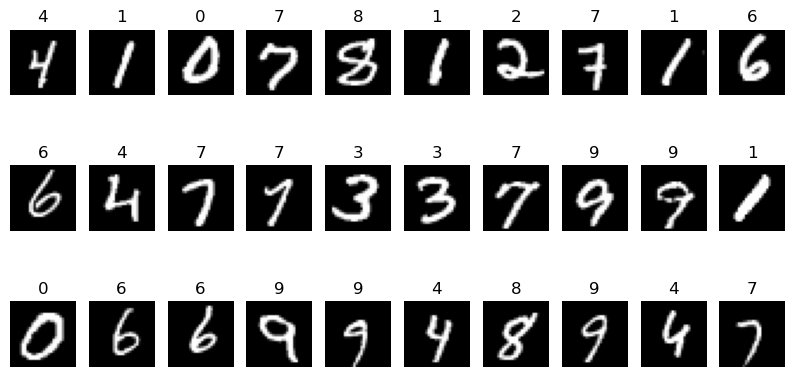

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 5]

ROWS = 3
COLS = 10

i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in data_train.take(ROWS * COLS):
    ax[int(i / COLS), i % COLS].axis("off")
    ax[int(i / COLS), i % COLS].set_title(str(label.numpy()))
    ax[int(i / COLS), i % COLS].imshow(np.reshape(image, (28, 28)), cmap="gray")
    i += 1

plt.show()

In [3]:
HEIGHT = 28
WIDTH = 28
CHANNELS = 1
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features["label"].num_classes

LAYER_SIZES = [28 * 28, 512, 10]
PARAM_SCALE = 0.01

2024-01-18 14:41:56.871180: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


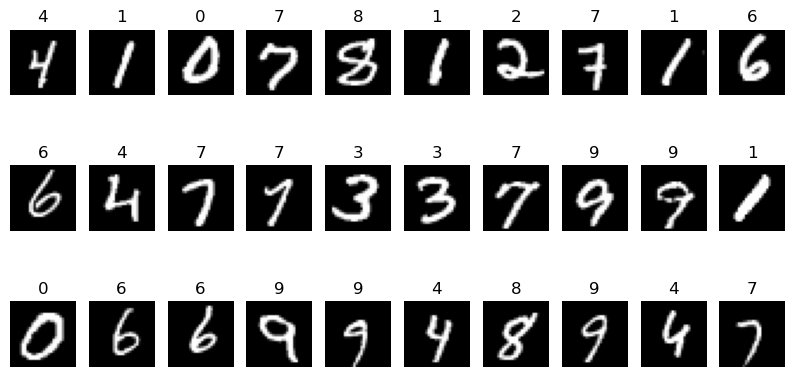

In [4]:
def preprocess(img, label):
    """Resize and preprocess images."""
    return (tf.cast(img, tf.float32) / 255.0), label


data_train_vis = data_train.map(preprocess)

i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in data_train_vis.take(ROWS * COLS):
    ax[int(i / COLS), i % COLS].axis("off")
    ax[int(i / COLS), i % COLS].set_title(str(label.numpy()))
    ax[int(i / COLS), i % COLS].imshow(np.reshape(image, (28, 28)), cmap="gray")
    i += 1

plt.show()

In [5]:
train_data = tfds.as_numpy(data_train.map(preprocess).batch(32).prefetch(1))
test_data = tfds.as_numpy(data_test.map(preprocess).batch(32).prefetch(1))

# Jax Random module

1. **Start with a single PRNGKey**: Begin with a single key for your main function or module.
2. **Split for Different Uses:** Use split to generate subkeys for different parts of your code that require independent randomness.

In [6]:
import jax.numpy as jnp
from jax._src import random

In [7]:
seed = random.PRNGKey(42)
seed

Array([ 0, 42], dtype=uint32)

In [8]:
a_key, b_key = random.split(key=random.PRNGKey(seed=0))
a_key, b_key

(Array([4146024105,  967050713], dtype=uint32),
 Array([2718843009, 1272950319], dtype=uint32))

In [9]:
random.split(a_key, num=3)

Array([[3115665281, 2516762499],
       [3202183753, 2203447534],
       [3814368215, 3795793182]], dtype=uint32)

In [10]:
random.normal(a_key, (2, 2))

Array([[ 0.13893168,  1.3706679 ],
       [-0.53116107,  0.02033782]], dtype=float32)

## init network params

In [11]:
def init_network_params(sizes, key=random.PRNGKey(0), scale=1e-2):
    """Initialize all layers for a fully-connected neural network with given sizes"""

    def random_layer_params(m, n, key, scale=1e-2):
        """A helper function to randomly initialize weights and biases of a dense layer"""
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

    keys = random.split(key, len(sizes))
    return [
        random_layer_params(m, n, k, scale)
        for m, n, k in zip(sizes[:-1], sizes[1:], keys)
    ]

In [12]:
params = init_network_params(LAYER_SIZES, random.PRNGKey(0), scale=PARAM_SCALE)

In [13]:
# def print_network_shape(params: NetworkParams):
#     for layer_name in params._fields:
#         param = getattr(params, layer_name)
#         print(layer_name)
#         for param_name in param._fields:
#             print(f"\t{param_name :8}: {getattr(param,param_name).shape}")


# print_network_shape(network_params)

In [14]:
import jax

jax.tree_map(lambda x: x.shape, params)

[((512, 784), (512,)), ((10, 512), (10,))]

## Neural Network

In [15]:
import jax.numpy as jnp
from jax.nn import swish

In [16]:
def predict(params, image):
    """Function for per-example predictions."""
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = swish(outputs)

    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits

In [17]:
random_flattened_image = random.normal(random.PRNGKey(1), (28 * 28 * 1,))
preds = predict(params, random_flattened_image)
print(preds.shape)

(10,)


In [18]:
random_flattened_images = random.normal(random.PRNGKey(1), (32, 28 * 28 * 1))
try:
    preds = predict(params, random_flattened_images)
except TypeError as e:
    print(e)

dot_general requires contracting dimensions to have the same shape, got (784,) and (32,).


## vmap

In [19]:
from jax import vmap

### how to use vmap

#### vector dot product

In [20]:
def get_seq_tensor(*shape):
    shape = jnp.array(shape)
    return jnp.arange(1, shape.prod() + 1).reshape(shape)


get_seq_tensor(2, 2)

Array([[1, 2],
       [3, 4]], dtype=int32)

In [21]:
vec_dot_fn = lambda x, y: jnp.vdot(x, y)

dot_res = vec_dot_fn(get_seq_tensor(2), get_seq_tensor(2))
print(dot_res.shape)

try:
    batch_dot = vec_dot_fn(get_seq_tensor(2, 2), get_seq_tensor(2))
except TypeError as e:
    print(e)

()
dot_general requires contracting dimensions to have the same shape, got (4,) and (2,).


#### batch dot product

In [22]:
bat_dot_fn = vmap(vec_dot_fn, in_axes=(0, None), out_axes=0)

batch_dot = bat_dot_fn(get_seq_tensor(2, 2), get_seq_tensor(2))
print(batch_dot.shape)

(2,)


#### mat mul

In [23]:
mat_mul_fn = vmap(bat_dot_fn, in_axes=(None, 1), out_axes=1)
mat_mul_res = mat_mul_fn(get_seq_tensor(3, 2), get_seq_tensor(2, 4))

jnp.allclose(mat_mul_res, get_seq_tensor(3, 2) @ get_seq_tensor(2, 4))

Array(True, dtype=bool)

### batch predict

In [24]:
batched_predict = vmap(predict, in_axes=(None, 0))

batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(32, 10)


In [25]:
jax.devices()

[cuda(id=0)]

## loss

In [26]:
INIT_LR = 1.0
DECAY_RATE = 0.95
DECAY_STEPS = 5


num_epochs = 25

In [27]:
from jax.nn import logsumexp, one_hot
from jax import value_and_grad, jit


def loss(params, images, targets):
    """Categorical cross entropy loss function."""
    logits = batched_predict(params, images)
    log_preds = logits - logsumexp(
        logits
    )  # logsumexp trick https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    return -jnp.mean(targets * log_preds)


@jit
def update(params, x, y, epoch_number):
    loss_value, grads = value_and_grad(loss)(params, x, y)
    lr = INIT_LR * DECAY_RATE ** (epoch_number / DECAY_STEPS)
    return [
        (w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)
    ], loss_value

In [28]:
@jit
def batch_accuracy(params, images, targets):
    images = jnp.reshape(images, (len(images), NUM_PIXELS))
    predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
    return jnp.mean(predicted_class == targets)


def accuracy(params, data):
    accs = []
    for images, targets in data:
        accs.append(batch_accuracy(params, images, targets))
    return jnp.mean(jnp.array(accs))


import time

for epoch in range(num_epochs):
    start_time = time.time()
    losses = []
    for x, y in train_data:
        x = jnp.reshape(x, (len(x), NUM_PIXELS))
        y = one_hot(y, NUM_LABELS)
        params, loss_value = update(params, x, y, epoch)
        losses.append(loss_value)
    epoch_time = time.time() - start_time

    start_time = time.time()
    train_acc = accuracy(params, train_data)
    test_acc = accuracy(params, test_data)
    eval_time = time.time() - start_time
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Eval in {:0.2f} sec".format(eval_time))
    print("Training set loss {}".format(jnp.mean(jnp.array(losses))))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))

Epoch 0 in 0.92 sec
Eval in 1.12 sec
Training set loss 0.41040655970573425
Training set accuracy 0.9299499988555908
Test set accuracy 0.931010365486145
Epoch 1 in 0.51 sec
Eval in 0.54 sec
Training set loss 0.37730300426483154
Training set accuracy 0.9499666690826416
Test set accuracy 0.9497803449630737
Epoch 2 in 0.51 sec
Eval in 0.54 sec
Training set loss 0.3708731234073639
Training set accuracy 0.9603333473205566
Test set accuracy 0.9593650102615356
Epoch 3 in 0.52 sec
Eval in 0.55 sec
Training set loss 0.3674814999103546
Training set accuracy 0.9666333198547363
Test set accuracy 0.9640575051307678
Epoch 4 in 0.50 sec
Eval in 0.56 sec
Training set loss 0.36519238352775574
Training set accuracy 0.9704166650772095
Test set accuracy 0.9673522114753723
Epoch 5 in 0.51 sec
Eval in 0.54 sec
Training set loss 0.3634973168373108
Training set accuracy 0.9737333655357361
Test set accuracy 0.9694488644599915
Epoch 6 in 0.51 sec
Eval in 0.51 sec
Training set loss 0.36217647790908813
Training se